In [122]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [123]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [124]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [125]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

In [126]:
uniprot_id = "P0DMS8" # uniprot_id for the A3 receptor

In [127]:
# Here I select the target information from ChEMBL and select only a few columns
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [128]:
targets = pd.DataFrame.from_records(targets)
targets # these are the targets that were fetched from ChEMBL

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Adenosine A3 receptor,CHEMBL256,SINGLE PROTEIN
1,Homo sapiens,Adenosine A3 receptor,CHEMBL256,SINGLE PROTEIN
2,Homo sapiens,Adenosine receptors; A1 & A3,CHEMBL2095195,SELECTIVITY GROUP
3,Homo sapiens,Adenosine receptors; A2a & A3,CHEMBL2095213,SELECTIVITY GROUP
4,Homo sapiens,Adenosine receptors; A2b & A3,CHEMBL2095234,SELECTIVITY GROUP
5,Homo sapiens,Adenosine receptor,CHEMBL2111329,PROTEIN FAMILY


In [129]:
target = targets.iloc[0]
target # we select the first from the targets

organism                     Homo sapiens
pref_name           Adenosine A3 receptor
target_chembl_id                CHEMBL256
target_type                SINGLE PROTEIN
Name: 0, dtype: object

In [130]:
chembl_id = target.target_chembl_id # now we name it chembl_id
print(f"The target ChEMBL ID is {chembl_id}") # we double check if we have the right one selected

The target ChEMBL ID is CHEMBL256


In [131]:
# Time to fetch bioactivity data from ChEMBL
# specify the type to select at 'type=""', this time we used Ki instead of IC50

bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="Ki", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

#This gives us a list with 4965 data points

Length and type of bioactivities object: 4965, <class 'chembl_webresource_client.query_set.QuerySet'>


In [132]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]
# these are all the columns of the dataframe we are about to make
# basically double check again if everything went right, we can see that it did

Length and type of first element: 13, <class 'dict'>


{'activity_id': 38532,
 'assay_chembl_id': 'CHEMBL641522',
 'assay_description': 'In vitro binding affinity at human Adenosine A3 receptor from HEK293 cells by [125I]AB-MECA displacement.',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL319971',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '14.6',
 'target_chembl_id': 'CHEMBL256',
 'target_organism': 'Homo sapiens',
 'type': 'Ki',
 'units': 'nM',
 'value': '14.6'}

In [133]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

# we now made a dataframe with compounds that have a Ki value associated with the A3 receptor

DataFrame shape: (4966, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,38532,CHEMBL641522,In vitro binding affinity at human Adenosine A...,B,CHEMBL319971,=,nM,14.6,CHEMBL256,Homo sapiens,Ki,nM,14.6
1,38532,CHEMBL641522,In vitro binding affinity at human Adenosine A...,B,CHEMBL319971,=,nM,14.6,CHEMBL256,Homo sapiens,Ki,nM,14.6
2,38794,CHEMBL641961,Displacement of [3H]MRE3008-F20 from human A3 ...,B,CHEMBL132806,=,nM,81.0,CHEMBL256,Homo sapiens,Ki,nM,81.0
3,39649,CHEMBL641522,In vitro binding affinity at human Adenosine A...,B,CHEMBL88147,=,nM,0.65,CHEMBL256,Homo sapiens,Ki,nM,0.65
4,39654,CHEMBL641522,In vitro binding affinity at human Adenosine A...,B,CHEMBL97383,=,nM,1813.0,CHEMBL256,Homo sapiens,Ki,nM,1813.0


In [134]:
bioactivities_df["units"].unique()

array(['nM', 'uM', 'mM', '%', "10'-10M", "10'3nM", "10'-11M", 'µM'],
      dtype=object)

In [135]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True) # drop two columns we don't need
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,38532,CHEMBL641522,In vitro binding affinity at human Adenosine A...,B,CHEMBL319971,=,nM,14.6,CHEMBL256,Homo sapiens,Ki
1,38532,CHEMBL641522,In vitro binding affinity at human Adenosine A...,B,CHEMBL319971,=,nM,14.6,CHEMBL256,Homo sapiens,Ki
2,38794,CHEMBL641961,Displacement of [3H]MRE3008-F20 from human A3 ...,B,CHEMBL132806,=,nM,81.0,CHEMBL256,Homo sapiens,Ki
3,39649,CHEMBL641522,In vitro binding affinity at human Adenosine A...,B,CHEMBL88147,=,nM,0.65,CHEMBL256,Homo sapiens,Ki
4,39654,CHEMBL641522,In vitro binding affinity at human Adenosine A...,B,CHEMBL97383,=,nM,1813.0,CHEMBL256,Homo sapiens,Ki


In [136]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [137]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes #to transform Ki into pKi, the 'standard_value' column must be a float

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

In [138]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (4966, 11)


In [139]:
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM' '%' 'µM']
Number of non-nM entries:    7


In [140]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}") # only entries with standard_unit nM will be kept

Units after filtering: ['nM']


In [141]:
print(f"DataFrame shape: {bioactivities_df.shape}") # check how many rows > only a few entries were dropped

DataFrame shape: (4959, 11)


In [142]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}") # removes duplicates > now more than a thousand entries were dropped


DataFrame shape: (3951, 11)


In [143]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,38532,CHEMBL641522,In vitro binding affinity at human Adenosine A...,B,CHEMBL319971,=,nM,14.60,CHEMBL256,Homo sapiens,Ki
1,38794,CHEMBL641961,Displacement of [3H]MRE3008-F20 from human A3 ...,B,CHEMBL132806,=,nM,81.00,CHEMBL256,Homo sapiens,Ki
2,39649,CHEMBL641522,In vitro binding affinity at human Adenosine A...,B,CHEMBL88147,=,nM,0.65,CHEMBL256,Homo sapiens,Ki
3,39654,CHEMBL641522,In vitro binding affinity at human Adenosine A...,B,CHEMBL97383,=,nM,1813.00,CHEMBL256,Homo sapiens,Ki
4,39910,CHEMBL641961,Displacement of [3H]MRE3008-F20 from human A3 ...,B,CHEMBL336217,=,nM,215.00,CHEMBL256,Homo sapiens,Ki


In [144]:
bioactivities_df.rename(
    columns={"standard_value": "Ki", "standard_units": "units"}, inplace=True
)
bioactivities_df.head() # renaming of columns

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,Ki,target_chembl_id,target_organism,type
0,38532,CHEMBL641522,In vitro binding affinity at human Adenosine A...,B,CHEMBL319971,=,nM,14.60,CHEMBL256,Homo sapiens,Ki
1,38794,CHEMBL641961,Displacement of [3H]MRE3008-F20 from human A3 ...,B,CHEMBL132806,=,nM,81.00,CHEMBL256,Homo sapiens,Ki
2,39649,CHEMBL641522,In vitro binding affinity at human Adenosine A...,B,CHEMBL88147,=,nM,0.65,CHEMBL256,Homo sapiens,Ki
3,39654,CHEMBL641522,In vitro binding affinity at human Adenosine A...,B,CHEMBL97383,=,nM,1813.00,CHEMBL256,Homo sapiens,Ki
4,39910,CHEMBL641961,Displacement of [3H]MRE3008-F20 from human A3 ...,B,CHEMBL336217,=,nM,215.00,CHEMBL256,Homo sapiens,Ki


In [145]:
print(f"DataFrame shape: {bioactivities_df.shape}") # check how many columns

DataFrame shape: (3951, 11)


In [146]:
# Now we can fetch compound data for the list we created
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [147]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/3951 [00:00<?, ?it/s]

In [148]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}") # new df with only smiles and chembl_id's

DataFrame shape: (3951, 2)


In [149]:
compounds_df.head() # check

,molecule_chembl_id,molecule_structures
0,CHEMBL408,{'canonical_smiles': 'Cc1c(C)c2c(c(C)c1O)CCC(C...
1,CHEMBL411,{'canonical_smiles': 'CC/C(=C(/CC)c1ccc(O)cc1)...
2,CHEMBL7002,{'canonical_smiles': 'CC1(COc2ccc(CC3SC(=O)NC3...
3,CHEMBL38,{'canonical_smiles': 'CC1=C(/C=C/C(C)=C/C=C/C(...
4,CHEMBL7266,{'canonical_smiles': 'Nc1nc2ccc(Cl)cc2c2nc(-c3...


In [150]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3945, 2)


In [151]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}") # no duplicate entries in this case

DataFrame shape: (3945, 2)


In [152]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [153]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}") # transforms the smiles column into workable entries
compounds_df.head() # check if it worked

DataFrame shape: (3945, 2)


,molecule_chembl_id,smiles
0,CHEMBL408,Cc1c(C)c2c(c(C)c1O)CCC(C)(COc1ccc(CC3SC(=O)NC3...
1,CHEMBL411,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1
2,CHEMBL7002,CC1(COc2ccc(CC3SC(=O)NC3=O)cc2)CCCCC1
3,CHEMBL38,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)C(C)(C)CCC1
4,CHEMBL7266,Nc1nc2ccc(Cl)cc2c2nc(-c3ccc(Br)o3)nn12


In [154]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")
print()

DataFrame shape: (3945, 2)



In [155]:
# Now we can output the bioactivity data
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 3951


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'Ki', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [156]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 3945


Index(['molecule_chembl_id', 'smiles'], dtype='object')

In [157]:
# We merge the dataframes from the two notebooks above on the column ChEMBL_ID
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "Ki", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

output_df.reset_index(drop=True, inplace=True) # reset index

print(f"Dataset with {output_df.shape[0]} entries.") # check the amount of entries

Dataset with 3945 entries.


In [158]:
output_df.dtypes

molecule_chembl_id     object
Ki                    float64
units                  object
smiles                 object
dtype: object

In [159]:
output_df.head(10)

,molecule_chembl_id,Ki,units,smiles
0,CHEMBL319971,14.60,nM,CCCC(=O)Nc1nc2ccc(Cl)cc2c2nc(-c3ccco3)nn12
1,CHEMBL132806,81.00,nM,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...
2,CHEMBL88147,0.65,nM,O=C(Cc1ccccc1)Nc1nc2ccc(Cl)cc2c2nc(-c3ccco3)nn12
3,CHEMBL97383,1813.00,nM,CCCn1c(=O)n2nc(-c3ccco3)nc2c2cc(Cl)ccc21
4,CHEMBL336217,215.00,nM,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...
5,CHEMBL318251,13.90,nM,CC(=O)Nc1nc2ccc(Cl)cc2c2nc(-c3ccco3)nn12
6,CHEMBL100195,32.90,nM,CC(C)(C)OC(=O)NCCCC(=O)Nc1nc2ccc(Cl)cc2c2nc(-c...
7,CHEMBL134566,121.00,nM,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...
8,CHEMBL435022,50.00,nM,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...
9,CHEMBL341376,0.81,nM,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1


In [160]:
# function to convert Ki into pKi
def convert_ki_to_pki(Ki_value):
    pKi_value = 9 - math.log10(Ki_value)
    return pKi_value

In [161]:
# We apply this function to each entry and create a new column for it
output_df["pKi"] = output_df.apply(lambda x: convert_ki_to_pki(x.Ki), axis=1)

In [162]:
output_df.head(10) # check if it went right

,molecule_chembl_id,Ki,units,smiles,pKi
0,CHEMBL319971,14.60,nM,CCCC(=O)Nc1nc2ccc(Cl)cc2c2nc(-c3ccco3)nn12,7.835647
1,CHEMBL132806,81.00,nM,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,7.091515
2,CHEMBL88147,0.65,nM,O=C(Cc1ccccc1)Nc1nc2ccc(Cl)cc2c2nc(-c3ccco3)nn12,9.187087
3,CHEMBL97383,1813.00,nM,CCCn1c(=O)n2nc(-c3ccco3)nc2c2cc(Cl)ccc21,5.741602
4,CHEMBL336217,215.00,nM,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...,6.667562
5,CHEMBL318251,13.90,nM,CC(=O)Nc1nc2ccc(Cl)cc2c2nc(-c3ccco3)nn12,7.856985
6,CHEMBL100195,32.90,nM,CC(C)(C)OC(=O)NCCCC(=O)Nc1nc2ccc(Cl)cc2c2nc(-c...,7.482804
7,CHEMBL134566,121.00,nM,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,6.917215
8,CHEMBL435022,50.00,nM,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...,7.301030
9,CHEMBL341376,0.81,nM,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1,9.091515


array([[<Axes: title={'center': 'pKi'}>]], dtype=object)

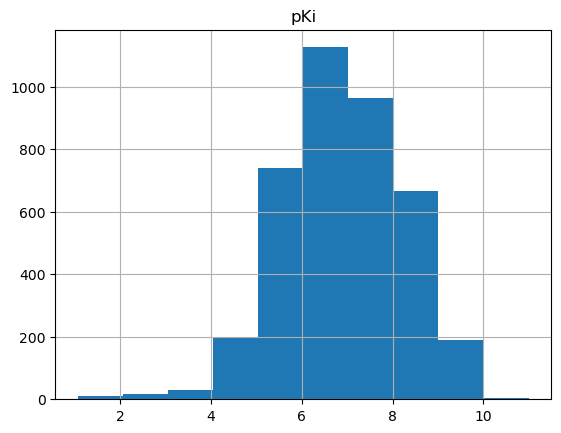

In [163]:
output_df.hist(column="pKi") # plot the compound data to visualize the distribution of pKi values that we compiled
# a pKi of around 6 might be a binder, but not that potent, from 8 upwards we could consider the compounds to be strong binders

In [164]:
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles") #ROMol column is added to the df, but will be dropped soon before saving

In [165]:
output_df.sort_values(by="pKi", ascending=False, inplace=True) # the list is sorted with highest pKi first
output_df.reset_index(drop=True, inplace=True) # reset index

,molecule_chembl_id,Ki,units,smiles,pKi,ROMol
0,CHEMBL118923,0.0100,nM,Cl.Cn1cc2c(nc(NC(=O)Nc3ccncc3)n3nc(-c4ccco4)nc...,11.000000,<rdkit.Chem.rdchem.Mol object at 0x7f17df969190>
1,CHEMBL3754229,0.0270,nM,COc1ccc(C(=O)Nc2nc(-c3cccs3)nc3cn(-c4ccccc4)nc...,10.568636,<rdkit.Chem.rdchem.Mol object at 0x7f17df92e900>
2,CHEMBL89852,0.0314,nM,CCO/C(O)=C1\C(C)=NC(c2ccccc2)=C(C(=O)OCc2ccccc...,10.503070,<rdkit.Chem.rdchem.Mol object at 0x7f17df959120>
3,CHEMBL332091,0.0400,nM,Cn1cc2c(nc(NC(=O)Nc3ccncc3)n3nc(-c4ccco4)nc23)n1,10.397940,<rdkit.Chem.rdchem.Mol object at 0x7f17df96a510>
4,CHEMBL1091268,0.1080,nM,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccccc4)nc23)n1,9.966576,<rdkit.Chem.rdchem.Mol object at 0x7f17df912350>


In [166]:
output_df.drop("smiles", axis=1).head(10)

,molecule_chembl_id,Ki,units,smiles,pKi,ROMol
0,CHEMBL118923,0.0100,nM,Cl.Cn1cc2c(nc(NC(=O)Nc3ccncc3)n3nc(-c4ccco4)nc...,11.000000,<rdkit.Chem.rdchem.Mol object at 0x7f17df969190>
1,CHEMBL3754229,0.0270,nM,COc1ccc(C(=O)Nc2nc(-c3cccs3)nc3cn(-c4ccccc4)nc...,10.568636,<rdkit.Chem.rdchem.Mol object at 0x7f17df92e900>
2,CHEMBL89852,0.0314,nM,CCO/C(O)=C1\C(C)=NC(c2ccccc2)=C(C(=O)OCc2ccccc...,10.503070,<rdkit.Chem.rdchem.Mol object at 0x7f17df959120>
3,CHEMBL332091,0.0400,nM,Cn1cc2c(nc(NC(=O)Nc3ccncc3)n3nc(-c4ccco4)nc23)n1,10.397940,<rdkit.Chem.rdchem.Mol object at 0x7f17df96a510>
4,CHEMBL1091268,0.1080,nM,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccccc4)nc23)n1,9.966576,<rdkit.Chem.rdchem.Mol object at 0x7f17df912350>


In [167]:
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (3945, 5)


In [119]:
# Now we save the smiles column as a txt file
dfsmiles = output_df['smiles']
display(dfsmiles)
export_directory = input('home/jovyan/project')
dfsmiles.to_csv('a3_ligands_ki_smiles.txt')

# the following is for when i want it as a .csv file
#pd.read_csv('a3_ligands_ki_smiles.txt')
#dfsmiles.to_csv('/home/jovyan/project' + "/a3_ligands_ki_smiles.csv")

# i also saved the list in a version with the following columns: molecule_chembl_id,Ki,units,smiles,pKi
#output_df.to_csv('a3_ligands_ki.txt')

0       Cl.Cn1cc2c(nc(NC(=O)Nc3ccncc3)n3nc(-c4ccco4)nc...
1       COc1ccc(C(=O)Nc2nc(-c3cccs3)nc3cn(-c4ccccc4)nc...
2       CCO/C(O)=C1\C(C)=NC(c2ccccc2)=C(C(=O)OCc2ccccc...
3        Cn1cc2c(nc(NC(=O)Nc3ccncc3)n3nc(-c4ccco4)nc23)n1
4       Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccccc4)nc23)n1
                              ...                        
3940                           Oc1nc(-c2ccccn2)cc2ccccc12
3941             CC(=O)N(C(C)=O)c1nc(-c2ccccn2)cc2ccccc12
3942                 CC(C)C(=O)Nc1nc(-c2ccccn2)cc2ccccc12
3943              CC(C)(C)c1nc(NC(=O)Nc2ccccc2)c2ccccc2n1
3944              O=C(Nc1nc(-c2ccccn2)nc2ccccc12)C(F)(F)F
Name: smiles, Length: 3945, dtype: object